In [1]:
df_import_location = 'datasets/goemotions/ekman_single/full_subset/goemotions_ekman_single_400_all_labels.csv'

In [2]:
import pandas as pd

df = pd.read_csv(df_import_location)
df

,original index,text,crowdsourced,dave,tim,jacob,fgcu_combined,llama3.1:8b-instruct-q8_0,deepseek-r1:14b,gpt-4o-mini,o3-mini
0,12234,"Hey thanks, I appreciate it!",joy,joy,joy,joy,joy,joy,joy,joy,joy
1,24303,I'm actually amazed we walked away with 2 poin...,neutral,disgust,joy,surprise,NaN,surprise,surprise,surprise,surprise
2,34179,"Still, it’s legal weed. Sorry, sad [NAME] here..",sadness,sadness,sadness,sadness,sadness,sadness,sadness,sadness,sadness
3,33745,"I love the guy who is like ""the analogy is daf...",love,anger,anger,joy,anger,joy,joy,joy,joy
4,37891,maybe they need Congress to pass a bill to mak...,neutral,anger,anger,anger,anger,anger,neutral,anger,anger
...,...,...,...,...,...,...,...,...,...,...,...
395,11894,I did this with tuna salad. I already ate tuna...,neutral,joy,joy,surprise,joy,neutral,neutral,neutral,neutral
396,32032,I love how dramatic it is. It's perfectly self...,love,joy,joy,joy,joy,joy,joy,joy,joy
397,22189,I am so relieved,joy,joy,joy,joy,joy,joy,joy,joy,joy
398,45855,I sense no awful taste here.,disgust,joy,joy,neutral,joy,neutral,neutral,neutral,neutral


# Cohen's Kappa

In [3]:
from sklearn.metrics import cohen_kappa_score

annotator_columns = [col for col in df.columns if col not in ['text', 'original index']]
df_kappa = df.fillna("none")

kappa_matrix = pd.DataFrame(index=annotator_columns, columns=annotator_columns)

for a in annotator_columns:
    for b in annotator_columns:
        if a == b:
            kappa_matrix.loc[a, b] = 1.0  # Perfect agreement with itself
        else:
            kappa_matrix.loc[a, b] = cohen_kappa_score(df_kappa[a], df_kappa[b])


print(kappa_matrix)

                          crowdsourced      dave       tim     jacob  \
crowdsourced                       1.0    0.2347  0.232669   0.31356   
dave                            0.2347       1.0  0.525482  0.499824   
tim                           0.232669  0.525482       1.0  0.483677   
jacob                          0.31356  0.499824  0.483677       1.0   
fgcu_combined                 0.260953  0.731947  0.713804  0.690061   
llama3.1:8b-instruct-q8_0       0.2554  0.462549  0.480605  0.488885   
deepseek-r1:14b               0.317395  0.490569  0.437666   0.50052   
gpt-4o-mini                   0.254486  0.464108  0.480654   0.48855   
o3-mini                       0.269973  0.447608  0.451492  0.487816   

                          fgcu_combined llama3.1:8b-instruct-q8_0  \
crowdsourced                   0.260953                    0.2554   
dave                           0.731947                  0.462549   
tim                            0.713804                  0.480605   
jac

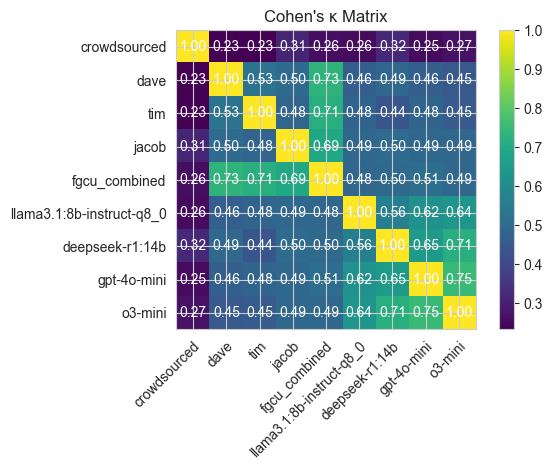

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Convert kappa_matrix to float if necessary
kappa_matrix_float = kappa_matrix.astype(float)

fig, ax = plt.subplots()
cax = ax.imshow(kappa_matrix_float, interpolation='nearest', cmap='viridis')
ax.set_title("Cohen's κ Matrix")

# Set tick positions and labels
num_annotators = len(kappa_matrix.columns)
ax.set_xticks(np.arange(num_annotators))
ax.set_yticks(np.arange(num_annotators))
ax.set_xticklabels(kappa_matrix.columns)
ax.set_yticklabels(kappa_matrix.index)

# Rotate the x-axis labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add a colorbar to show the scale
fig.colorbar(cax)

# Optionally, add numerical annotations in each cell
for i in range(num_annotators):
    for j in range(num_annotators):
        ax.text(j, i, f"{kappa_matrix_float.iloc[i, j]:.2f}",
                ha="center", va="center", color="w")

plt.tight_layout()
plt.show()


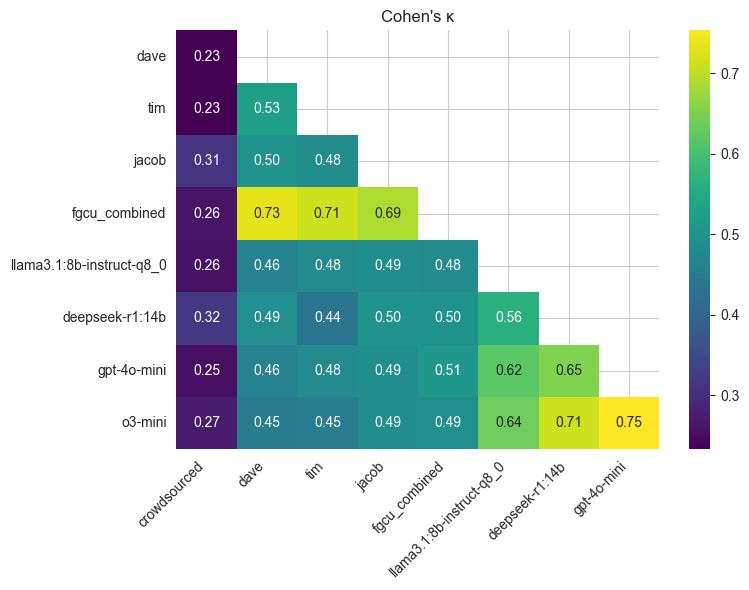

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a mask for the lower triangle, excluding the diagonal (k=-1)
mask_lower = np.tril(np.ones_like(kappa_matrix_float, dtype=bool), k=-1)
# Use the mask to keep only the lower triangle values
kappa_lower = kappa_matrix_float.where(mask_lower)

# Drop rows and columns that are entirely NaN (they have no lower-triangle comparisons)
kappa_lower = kappa_lower.dropna(axis=0, how='all').dropna(axis=1, how='all')

plt.figure(figsize=(8, 6))
ax = sns.heatmap(kappa_lower, annot=True, fmt=".2f", cmap="viridis",
                 xticklabels=kappa_lower.columns, yticklabels=kappa_lower.index)
plt.title("Cohen's κ")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import itertools

# Assume df is a dataframe where rows are documents and columns are annotators.
# Each cell contains an emotion label (e.g., 'joy', 'sadness', etc.).
# First, get the list of unique labels across the dataframe.
unique_labels = ["anger", "disgust", "joy", "sadness", "fear", "surprise", "neutral"]

annotators = df.columns.tolist()

# Dictionary to store kappa values for each label.
results = {}

for label in unique_labels:
    label_kappas = {}
    # For each pair of annotators, compute kappa for this label.
    for a1, a2 in itertools.combinations(annotators, 2):
        # Create binary series: 1 if the annotator applied the label, else 0.
        series_a1 = (df[a1] == label).astype(int)
        series_a2 = (df[a2] == label).astype(int)
        kappa = cohen_kappa_score(series_a1, series_a2)
        label_kappas[f"{a1} vs {a2}"] = kappa
    results[label] = label_kappas

# Print the pairwise Cohen's kappa values for each label.
for label, kappas in results.items():
    print(f"Label: {label}")
    for pair, kappa in kappas.items():
        print(f"  {pair}: {kappa}")


E:\Projects\PythonProject\Dataset_Labeling_via_GenAI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
E:\Projects\PythonProject\Dataset_Labeling_via_GenAI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
E:\Projects\PythonProject\Dataset_Labeling_via_GenAI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
E:\Projects\PythonProject\Dataset_Labeling_via_GenAI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:758: RuntimeWarning: invalid value encountered 

Label: anger
  original index vs text: nan
  original index vs crowdsourced: 0.0
  original index vs dave: 0.0
  original index vs tim: 0.0
  original index vs jacob: 0.0
  original index vs fgcu_combined: 0.0
  original index vs llama3.1:8b-instruct-q8_0: 0.0
  original index vs deepseek-r1:14b: 0.0
  original index vs gpt-4o-mini: 0.0
  original index vs o3-mini: 0.0
  text vs crowdsourced: 0.0
  text vs dave: 0.0
  text vs tim: 0.0
  text vs jacob: 0.0
  text vs fgcu_combined: 0.0
  text vs llama3.1:8b-instruct-q8_0: 0.0
  text vs deepseek-r1:14b: 0.0
  text vs gpt-4o-mini: 0.0
  text vs o3-mini: 0.0
  crowdsourced vs dave: 0.1592050666084298
  crowdsourced vs tim: 0.3134846076022546
  crowdsourced vs jacob: 0.35116004718836025
  crowdsourced vs fgcu_combined: 0.31456094849944427
  crowdsourced vs llama3.1:8b-instruct-q8_0: 0.3211073884676423
  crowdsourced vs deepseek-r1:14b: 0.3222308288148722
  crowdsourced vs gpt-4o-mini: 0.27160893493039817
  crowdsourced vs o3-mini: 0.27658142

E:\Projects\PythonProject\Dataset_Labeling_via_GenAI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
E:\Projects\PythonProject\Dataset_Labeling_via_GenAI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
E:\Projects\PythonProject\Dataset_Labeling_via_GenAI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
E:\Projects\PythonProject\Dataset_Labeling_via_GenAI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:758: RuntimeWarning: invalid value encountered 

# Krippendorff's Alpha

In [7]:
import simpledorff

annotator_columns = [col for col in df.columns if col not in ['text', 'original index']]

krippendorff_matrix = pd.DataFrame(index=annotator_columns, columns=annotator_columns)

for a in annotator_columns:
    for b in annotator_columns:
        if a == b:
            krippendorff_matrix.loc[a, b] = 1.0  # Perfect agreement with itself
        else:
            df_long = pd.melt(df[[a,b]].reset_index().rename(columns={'index': 'document_id'}),
                  id_vars=['document_id'],  # these columns remain fixed
                  var_name='annotator_id',  # name for the column indicating the original annotator column name
                  value_name='annotation')  # name for the column containing the annotation values

            krippendorff_matrix.loc[a, b] = simpledorff.calculate_krippendorffs_alpha_for_df(df_long,
                                                                                             experiment_col='document_id',
                                                                                             annotator_col='annotator_id',
                                                                                             class_col='annotation')

krippendorff_matrix

,crowdsourced,dave,tim,jacob,fgcu_combined,llama3.1:8b-instruct-q8_0,deepseek-r1:14b,gpt-4o-mini,o3-mini
crowdsourced,1.0,0.215607,0.202281,0.30328,0.263457,0.241773,0.313596,0.244853,0.263853
dave,0.215607,1.0,0.520009,0.497723,0.794457,0.459901,0.486192,0.458347,0.440227
tim,0.202281,0.520009,1.0,0.478911,0.775828,0.478404,0.429547,0.476076,0.443604
jacob,0.30328,0.497723,0.478911,1.0,0.748067,0.487543,0.499317,0.486621,0.48456
fgcu_combined,0.263457,0.794457,0.775828,0.748067,1.0,0.525336,0.537537,0.549911,0.528405
llama3.1:8b-instruct-q8_0,0.241773,0.459901,0.478404,0.487543,0.525336,1.0,0.562016,0.619757,0.634783
deepseek-r1:14b,0.313596,0.486192,0.429547,0.499317,0.537537,0.562016,1.0,0.651668,0.714279
gpt-4o-mini,0.244853,0.458347,0.476076,0.486621,0.549911,0.619757,0.651668,1.0,0.753684
o3-mini,0.263853,0.440227,0.443604,0.48456,0.528405,0.634783,0.714279,0.753684,1.0


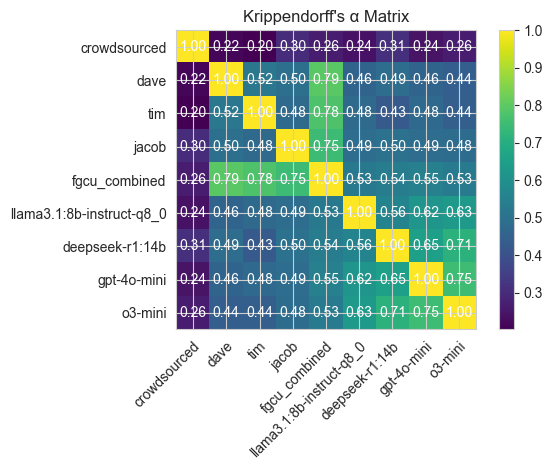

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Convert krippendorff_matrix to float if necessary
krippendorff_matrix_float = krippendorff_matrix.astype(float)

fig, ax = plt.subplots()
cax = ax.imshow(krippendorff_matrix_float, interpolation='nearest', cmap='viridis')
ax.set_title("Krippendorff's α Matrix")

# Set tick positions and labels
num_annotators = len(krippendorff_matrix.columns)
ax.set_xticks(np.arange(num_annotators))
ax.set_yticks(np.arange(num_annotators))
ax.set_xticklabels(krippendorff_matrix.columns)
ax.set_yticklabels(krippendorff_matrix.index)

# Rotate the x-axis labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add a colorbar to show the scale
fig.colorbar(cax)

# Optionally, add numerical annotations in each cell
for i in range(num_annotators):
    for j in range(num_annotators):
        ax.text(j, i, f"{krippendorff_matrix_float.iloc[i, j]:.2f}",
                ha="center", va="center", color="w")

plt.tight_layout()
plt.show()


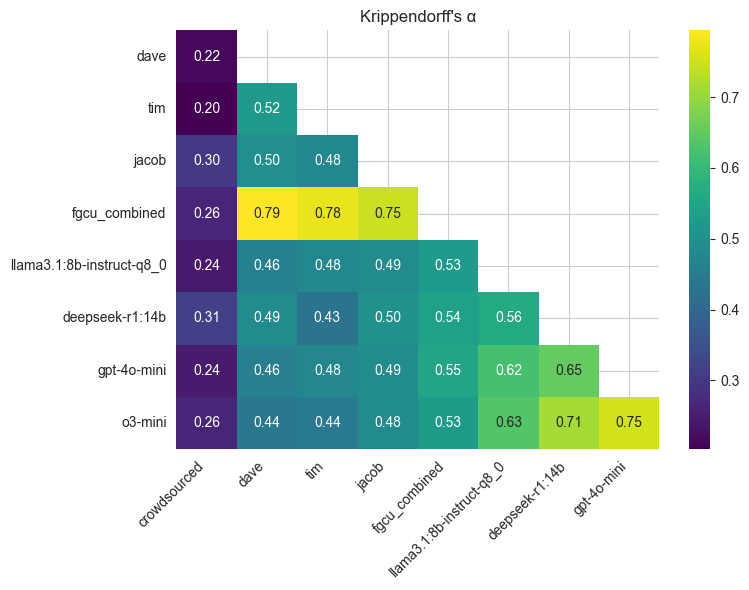

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a mask for the lower triangle, excluding the diagonal (k=-1)
mask_lower = np.tril(np.ones_like(krippendorff_matrix_float, dtype=bool), k=-1)
# Use the mask to keep only the lower triangle values
krippendorff_lower = krippendorff_matrix_float.where(mask_lower)

# Drop rows and columns that are entirely NaN (they have no lower-triangle comparisons)
krippendorff_lower = krippendorff_lower.dropna(axis=0, how='all').dropna(axis=1, how='all')

plt.figure(figsize=(8, 6))
ax = sns.heatmap(krippendorff_lower, annot=True, fmt=".2f", cmap="viridis",
                 xticklabels=krippendorff_lower.columns, yticklabels=krippendorff_lower.index)
plt.title("Krippendorff's α")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Weighting

In [10]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Define your emotion labels
labels = ["anger", "disgust", "joy", "sadness", "fear", "surprise", "unemotional"]

# Load a pre-trained model (e.g., all-mpnet-base-v2)
model = SentenceTransformer('all-mpnet-base-v2')

# Get embeddings for each label
embeddings = model.encode(labels)

# Compute the cosine similarity matrix between labels
similarity_matrix = cosine_similarity(embeddings)

# Convert similarity scores into a weight matrix for weighted Cohen's kappa
# For example, weight = 1 - similarity so that similar labels have a lower penalty
weight_matrix = 1 - similarity_matrix

# Optionally, create a DataFrame for better readability
similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
weight_df = pd.DataFrame(weight_matrix, index=labels, columns=labels)

display("Cosine Similarity Matrix:\n", similarity_df)
display("\nWeight Matrix for Kappa (1 - similarity):\n", weight_df.map('{:.2f}'.format))

E:\Projects\PythonProject\Dataset_Labeling_via_GenAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'Cosine Similarity Matrix:\n'

,anger,disgust,joy,sadness,fear,surprise,unemotional
anger,1.000000,0.688177,0.449712,0.514255,0.571348,0.384642,0.363623
disgust,0.688177,1.000000,0.389158,0.539255,0.556545,0.409764,0.392080
joy,0.449712,0.389158,1.000000,0.610921,0.481120,0.347285,0.251286
sadness,0.514255,0.539255,0.610921,1.000000,0.517641,0.346464,0.332464
fear,0.571348,0.556545,0.481120,0.517641,1.000000,0.295403,0.348933
surprise,0.384642,0.409764,0.347285,0.346464,0.295403,1.000000,0.304130
unemotional,0.363623,0.392080,0.251286,0.332464,0.348933,0.304130,1.000000


'\nWeight Matrix for Kappa (1 - similarity):\n'

,anger,disgust,joy,sadness,fear,surprise,unemotional
anger,0.00,0.31,0.55,0.49,0.43,0.62,0.64
disgust,0.31,-0.00,0.61,0.46,0.44,0.59,0.61
joy,0.55,0.61,0.00,0.39,0.52,0.65,0.75
sadness,0.49,0.46,0.39,-0.00,0.48,0.65,0.67
fear,0.43,0.44,0.52,0.48,0.00,0.70,0.65
surprise,0.62,0.59,0.65,0.65,0.70,-0.00,0.70
unemotional,0.64,0.61,0.75,0.67,0.65,0.70,-0.00
